In [1]:
import os
import numpy as np
import pickle
from scipy import signal
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import regularizers

/Users/irina/PycharmProjects/pythonProject1/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
DATA_PATH = '../data/deap-dataset/data_preprocessed_python'
PARTICIPANT_COUNT = 25
FS = 128
WINDOW_SIZE = 8
OVERLAP = 4

# Частотные диапазоны
BANDS = {
    'alpha': (8, 13),
    'beta': (14, 30),
    'theta': (4, 7),
    'gamma': (30, 45)
}

# Конфигурация обучения
EPOCHS = 20
BATCH_SIZE = 32
LEARNING_RATE = 0.0001
L2_REG = 0.01
DROPOUT_RATE = 0.5
PATIENCE_EARLYSTOP = 7
PATIENCE_REDUCELR = 3
LR_REDUCE_FACTOR = 0.5
MODEL_SAVE_PATH = '../data/eeg_emotion_model_cluster.keras'
RANDOM_STATE = 42

# Задача: 'valence' или 'cluster'
MODE = 'cluster'
NUM_CLASSES = 2 if MODE == 'valence' else 4

In [3]:
def bandpass_filter(data, low, high, fs=FS, order=5):
    nyq = 0.5 * fs
    low, high = low / nyq, high / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return signal.filtfilt(b, a, data)

In [4]:
def split_bands(eeg_data):
    band_data = {}
    for band, (low, high) in BANDS.items():
        filtered = np.zeros_like(eeg_data)
        for ch in range(eeg_data.shape[1]):
            filtered[:, ch, :] = bandpass_filter(eeg_data[:, ch, :], low, high)
        band_data[band] = filtered
    return band_data

In [5]:
def segment_data(data, window_size=WINDOW_SIZE, overlap=OVERLAP):
    n_trials, n_channels, n_samples = data.shape
    step, overlap_step = window_size * FS, overlap * FS
    segments = []
    for trial in range(n_trials):
        for i in range(0, n_samples - step + 1, overlap_step):
            segment = data[trial, :, i:i+step]
            segments.append(segment)
    return np.array(segments)

In [6]:
def extract_pcc(segments):
    return np.array([np.corrcoef(seg) for seg in segments])

In [7]:
def map_emotion_cluster(valence, arousal):
    if valence > 5 and arousal > 5:
        return 3
    elif valence > 5 and arousal <= 5:
        return 2
    elif valence <= 5 and arousal > 5:
        return 1
    else:
        return 0

In [8]:
def get_callbacks():
    return [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE_EARLYSTOP, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=PATIENCE_REDUCELR, factor=LR_REDUCE_FACTOR)
    ]

In [9]:
def create_model(input_shape, num_classes=NUM_CLASSES):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(L2_REG))(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(DROPOUT_RATE)(x)
    x = Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(L2_REG))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(L2_REG))(x)
    x = Dropout(DROPOUT_RATE)(x)
    if num_classes == 2:
        outputs = Dense(1, activation='sigmoid')(x)
        loss = 'binary_crossentropy'
    else:
        outputs = Dense(num_classes, activation='softmax')(x)
        loss = 'sparse_categorical_crossentropy'
    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(LEARNING_RATE), loss=loss, metrics=['accuracy'])
    return model

In [10]:
def load_deap_data():
    all_data, all_labels = [], []
    for i in tqdm(range(1, PARTICIPANT_COUNT + 1), desc="Загрузка участников"):
        file_path = os.path.join(DATA_PATH, f's{i:02d}.dat')
        with open(file_path, 'rb') as f:
            data = pickle.load(f, encoding='latin1')
            eeg_data = data['data'][:, :32, 3*FS:]
            gsr_data = data['data'][:, 37:38, 3*FS:]
            eeg_gsr_data = np.concatenate([eeg_data, gsr_data], axis=1)
            labels = data['labels']
            all_data.append(eeg_gsr_data)
            all_labels.append(labels)
    return np.concatenate(all_data), np.concatenate(all_labels)

In [11]:
print("\n[1] Загрузка и предобработка данных...")
eeg_data, labels = load_deap_data()

if MODE == 'valence':
    target_labels = (labels[:, 0] > 5).astype(int)
else:
    target_labels = np.array([map_emotion_cluster(v, a) for v, a in labels[:, :2]])

print("\n[2] Фильтрация и извлечение признаков...")
band_data = split_bands(eeg_data)
X, y = [], []
for band_name, data in band_data.items():
    segments = segment_data(data)
    pcc_features = extract_pcc(segments)
    n_segments = len(pcc_features)
    trial_labels = np.repeat(target_labels, n_segments // len(target_labels))
    X.append(pcc_features)
    y.append(trial_labels)

X = np.concatenate(X)[..., np.newaxis]
y = np.concatenate(y)

print(f"Форма данных: X={X.shape}, y={y.shape}")

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=RANDOM_STATE)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))


[1] Загрузка и предобработка данных...


Загрузка участников: 100%|██████████| 25/25 [00:01<00:00, 13.26it/s]



[2] Фильтрация и извлечение признаков...
Форма данных: X=(56000, 33, 33, 1), y=(56000,)


In [12]:
print("\n[3] Обучение модели...")
model = create_model(input_shape=X.shape[1:])
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test),
    class_weight=class_weight_dict,
    callbacks=get_callbacks(),
    verbose=1
)


[3] Обучение модели...
Epoch 1/20
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.3947 - loss: 2.5925 - val_accuracy: 0.3802 - val_loss: 1.3371 - learning_rate: 1.0000e-04
Epoch 2/20
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.4226 - loss: 1.2298 - val_accuracy: 0.3966 - val_loss: 1.1415 - learning_rate: 1.0000e-04
Epoch 3/20
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.4102 - loss: 1.1084 - val_accuracy: 0.4522 - val_loss: 1.0609 - learning_rate: 1.0000e-04
Epoch 4/20
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.4155 - loss: 1.0831 - val_accuracy: 0.3923 - val_loss: 1.0947 - learning_rate: 1.0000e-04
Epoch 5/20
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.4121 - loss: 1.0698 - val_accuracy: 0.4100 - val_loss: 1.0851 - learning_rate: 1.0000e-04
Epoch 6/20
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.4157 - loss: 1.0622 - val_accuracy: 0.4319 - val_loss: 1.0636 - learning_rate: 1.0000e-04
Epoch 7/20
1400/

In [13]:
model.save(MODEL_SAVE_PATH)

In [14]:
print("\n[4] Оценка модели...")
test_loss, test_acc = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int) if NUM_CLASSES == 2 else np.argmax(y_pred, axis=1)
print(f"\nТочность: {test_acc:.4f}, Потери: {test_loss:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


[4] Оценка модели...
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4514 - loss: 1.0470
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Точность: 0.4532, Потери: 1.0469

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.39      0.49      6104
           1       0.36      0.55      0.44      2834
           2       0.36      0.49      0.41      2262

    accuracy                           0.45     11200
   macro avg       0.45      0.48      0.45     11200
weighted avg       0.51      0.45      0.46     11200



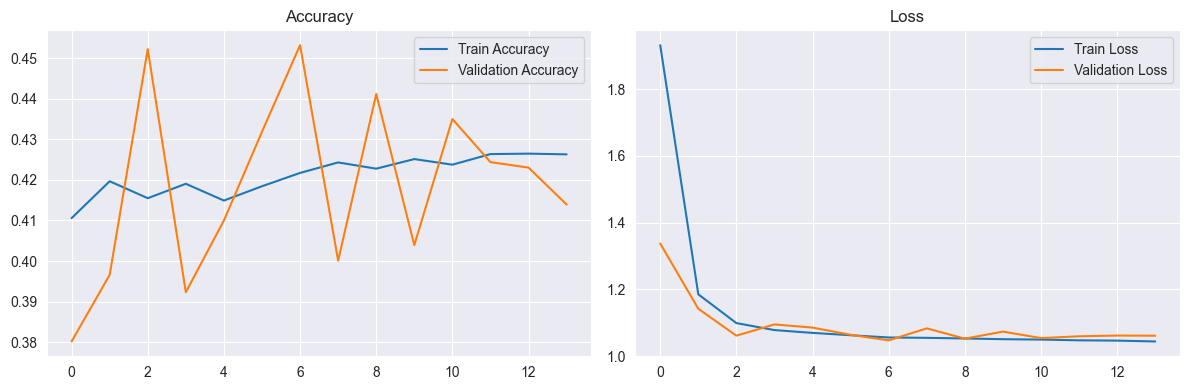

In [15]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.tight_layout()
plt.show()